# Introduction
The following is a case study based on an example from the *Analytics Vidhya DataHack platform* and involves a fictional company, __Dream Housing Finance__ company. This company deals in all home loans. They have a presence across all urban, semi-urban and rural areas. Customers first apply for a home loan and after that, Dream Housing Finance company validates the customer's eligibility. The company wants to automate the loan eligibility process in real-time, based on customer detail provided while filling online application form.

# Downloading and Exploring the Data
To start, we load the training and testing set into your python environment. We will use the [training](https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/train.csv) set to build our model, and the [test](https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/test.csv) set to validate it. Both the files are stored on the web as CSV files. We will load this data with the `pandas.read_csv()` function. It converts the data set to a python dataframe. In simple words, Python dataframe can be imagined as an equivalent of a spreadsheet or a SQL table.

In [1]:
# Import necesary libraries and remove warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from __future__ import division
import numpy as np
import pandas as pd

# Import training data as train
train = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/train.csv")

# Import testing data as test
test = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/test.csv")

# Print top 5 observation of training dataset
print "Top 5 observations in the training dataset:", "\n", "\n", train.head()

# Print the dimensions of the training dataset
print "Number of observations in the training dataset:", len(train)
print "Number of variables in the training dataset:", len(train.columns)

Top 5 observations in the training dataset: 

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                  0         NaN               360   
1             4583               1508         128               360   
2             3000                  0          66               360   
3             2583               2358         120               360   
4             6000                  0         141               360   

   Credit_History Property_Area Loan_Status  
0               1         Urban           Y  
1               1   

### Summary Statistics
Additionally we can do some summary statistics, usig the `dataframe.describe()` function, on the __numerical__ values of the training dataset. This will show us the *count*, *mean*, *standard deviation (sd)*, *min*, *quartiles* and max in its output.

In [2]:
# Look at the summary statistics of the numerical variables
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


For the __non-numeric__ (catagorical) values like `Property_Area`, `Credit_History` etc., we can look at frequency distribution. 

In [3]:
# Frequency distribution for `Property_Area`
train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
dtype: int64

In [4]:
# Frequency distribution for `Credit_History`
train['Credit_History'].value_counts()

1    475
0     89
dtype: int64

### Numerical Value Distribution
Now that we are familiar with basic data characteristics, we next look at the distribution of numerical variables. We start by plotting the histogram of `LoanAmount` and `ApplicantIncome` variables.

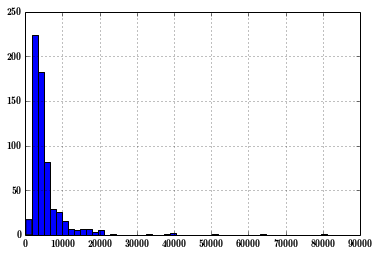

In [5]:
# Plot histogram for variable LoanAmount
train['ApplicantIncome'].hist(bins = 50)

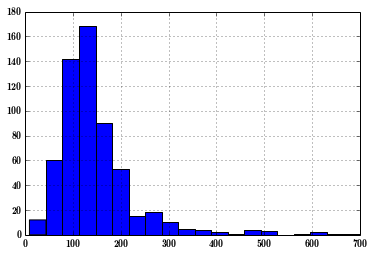

In [6]:
# Plot histogram for variable LoanAmount
train['LoanAmount'].hist(bins = 20)

We can further explore the `LoanAmount` distribution by breaking it down further based on the `Gender` catagory.

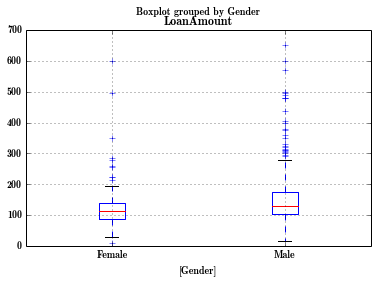

In [7]:
# Plot a box plot for variable LoanAmount by variable Gender of training data set
train.boxplot(column='LoanAmount', by = 'Gender')

### Catagorical Variable Distribution
We have looked at an example of the __numerical__ distributions of `ApplicantIncome` and `LoanIncome` and an example of how an applicants *Gender* may impact the decision. The above plot highlights that the distribution between Males and Females and the Loan Amount is not exactly alligned. This warrants further exploration, for instance, we can try see whether `Gender` is affecting the loan status or not. This can be tested using cross-tabulation, using the `crosstab()` function.

In [8]:
# Create a crosstab of `Gender` and `Loan_Status`
pd.crosstab(train['Gender'], train['Loan_Status'], margins = True)

Loan_Status,N,Y,All
Gender,,,
Female,37,75,112
Male,150,339,489
All,192,422,614


At first glance, it would seem that there are more loans approved for Males as opposed to Females, $339$ vs. $75$. But if we look closer, there are also more Male applicants than Female applications. So let's try and understand this within the context of proportions, using the `apply()` function.

In [9]:
# Define a function to convert to percentages
def percentages(x):
  return x/float(x[-1])

# Create a crosstab of `Gender~ and `Loan_status` and `apply` the above function 
pd.crosstab(train ["Gender"], train ["Loan_Status"], margins = True).apply(percentages, axis = 1)

Loan_Status,N,Y,All
Gender,,,
Female,0.330357,0.669643,1
Male,0.306748,0.693252,1
All,0.312704,0.687296,1


By looking at the proportions, we can see there is in fact no Gender discrimination as the amount of loan application approvals (as well as loan aplication rejections) between Males and Females are fairly equal. 

So from a data exploration exercise, it seems that we have an even distribution of data (both numerical and catagorical) in order to proceed.

# Cleaning the Data
### Dealing with Missing Values
Rarely is the data captured perfectly, and especially in the process of applying for a Home Loan, people may not disclose all details or the data may not be entered correctly. So the next task is look of potential missing values using the `isnull()` function.

In [10]:
# Look for missing values
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

So even though there are missing values in the dataset, not all of them impact wether or not a loan application is approved, however variables like `LoanAmount` are import. So the next step is to impute the missing values in the important variables.

There are multiple ways to fill the missing values of continuous variables. You can replace them with mean, median or estimate values based on other features of the data set. For the sake of simplicity, we would impute the missing values of `LoanAmount` by the __mean__ of the values for `LoanAmount` using the `fillna()` function. 

In [11]:
# Calculate the mean of the values for `LoanAmount`
print "Mean of the values for LoanAmount:", round(train['LoanAmount'].mean())

# Impute the missing values with the mean
train['LoanAmount'].fillna(train['LoanAmount'].mean(), inplace = True)

# Confirm no missing values
print "\n", "Does LoanAmount have missing values?", "\n", train['LoanAmount'].isnull().sum() > 0

Mean of the values for LoanAmount: 146.0

Does LoanAmount have missing values? 
False


But what about catagorical variables, like `Self_Employed`? To impute missing values of Categorical variables, we look at the frequency table. The simplest way is to impute with value which has highest frequency because there is a higher probability of success.

In [12]:
# Print the distribution of variabes
print train['Self_Employed'].value_counts()

# Print the percentage of 'No'
print "\n", "Precentage of No's:", \
round(train['Self_Employed'].value_counts()['No']/train['Self_Employed'].value_counts().sum() * 100, 2)

No     500
Yes     82
dtype: int64

Precentage of No's: 85.91


If we look at the distribution of `SelfEmployed`, $500$ out of $582$ which is aproximately $86%$ of total values falls under the category "No". So to impute the missing values in `SelfEmployed`, we will replace missing values with __No__. We will also apply this methadology to other important catagorical variables, `Gender` and `Credit_History`.

In [13]:
# Impute missing catagorical values
train['Self_Employed'].fillna('No', inplace = True)
train['Gender'].fillna('Male', inplace = True)
train['Credit_History'].fillna(1, inplace = True)
train.isnull().sum()

Loan_ID               0
Gender                0
Married               3
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

### Dealing with Outliers
Now that we have dealt with missing values, we can recall when plotting the distributions, that there are some extreme values. These values are important, so we don't want to discard them. For example, if we look at the `LoanAmount` variable we have some of these extreme values, which are completely viable as some applicants may require larger amounts depending on specific needs.

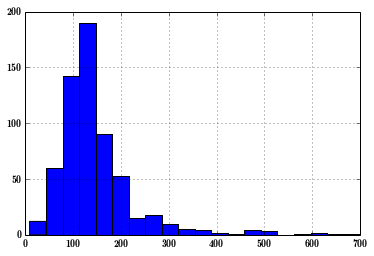

In [14]:
# Plot the distribution of `LoanAmount`
train['LoanAmount'].hist(bins = 20)

It's important to note though that when making predictions, these extreme values can potentially skew the results. So instead of treating them as outliers, we can try a log transformation to nullify their effect. The __numpy__ library has a number of functions like `log()` that allow us to do this.

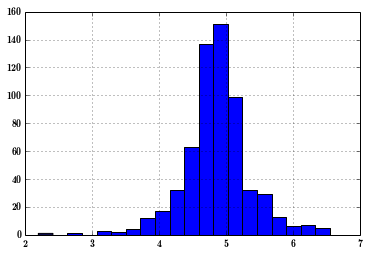

In [15]:
# Create a new varaible of the log transformation on `LoanAmount`
train['LoanAmount_log'] = np.log(train['LoanAmount'])

# Plot the new variable
train['LoanAmount_log'].hist(bins = 20)

Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided.

Next we can also consolidate some of the data to make our predictions easier. For instance, it is somewhat pointless to factor both the applicant's income as well as co-applicant's income as separate since in most cases, loan approval is based on joint income.

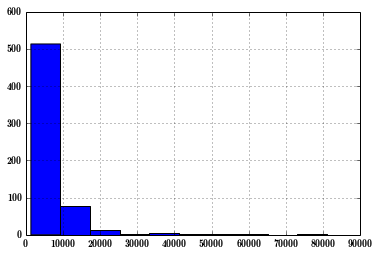

In [16]:
# Create new variable `TotalIncome`
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']

# Plot the new variable
train['TotalIncome'].hist()

As can been seen, this new variable also needs to be normalized.

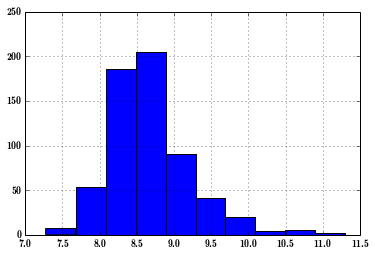

In [17]:
# Create a new normalized variable
train['Log_TotalIncome'] = np.log(train['TotalIncome'])

# Plot this new variable
train['Log_TotalIncome'].hist()

# Making Predictions
Since the scope of this case study is to make predictions of loan eligibility, we employ the __Scikit Learn__ library to start this process. It is important to note that Scikit Learn only works with numeric array. Hence, we need to label all the character variables into a numeric array. For example, the variable `Gender` has two labels, Male and Female. Hence, we will transform the labels to number as __1__ for *Male* and __0__ for *Female*. To do this, we will employ the module called `LabelEncoder`. This module helps to label character labels into numbers.

In [18]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Convert Male to 1 and Female to 0 in `Gender`
number = LabelEncoder()
train['Gender'] = number.fit_transform(train['Gender'].astype(str))

# Apply the same process to `Married`
train['Married'] = number.fit_transform(train['Married'].astype(str))

The basic principle behind selecting the right algorithm is to look at the dependent variable (or target variable). In this case study, it's __Loan Prediction__. Thus, we need to classify a customer's eligibility for Loan as *Y* or *N* based on the available information about the customer. Here the dependent variable is categorical and our task is to classify the customer in two groups; eligible for the loan amount and not eligible for the loan amount. This is a classification exercise, so we will initialy just try __Logistic Regression__. 

Before starting the classification exercise, we will prepare the environment by doing the following:
1. Import the necessary libaraies.
2. Download a fresh set of training and test datasets.
3. Pre-process the data. (i.e. fill in missng vales; encode catacogical variables; add `TotalIncome` etc.)
4. Create a generic function for the classification model.

Using these steps, will allow us to create a framework that can be re-used to execute other models without having to manually perform transformations or manually generate customizations for each algorithm and as such, framework can be applied later to other __Classification__ alorithms.

__Note:__ The `classify()` function also includes a cross-validation step to help improve model accuracy, before applying the model to test dataset.

In [19]:
# Re-import Import libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   # For K-fold cross validation
#from sklearn.ensemble import RandomForestClassifier # For later testing
#from sklearn.tree import DecisionTreeClassifier, export_graphviz # For later testing
from sklearn import metrics

# Download a fresh training and testing data
train_modified = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/train.csv")
test_modified = pd.read_csv("https://s3-ap-southeast-1.amazonaws.com/av-datahack-datacamp/test.csv")

# Clean the training data
train_modified['Gender'].fillna(train_modified['Gender'].mode()[0], inplace = True)
train_modified['Married'].fillna(train_modified['Married'].mode()[0], inplace = True)
train_modified['Dependents'].fillna(train_modified['Dependents'].mode()[0], inplace = True)
train_modified['Credit_History'].fillna(train_modified['Credit_History'].mode()[0], inplace = True)
catagoricals = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
for var in catagoricals:
    label = LabelEncoder()
    train_modified[var]=label.fit_transform(train_modified[var].astype('str'))
train_modified['LoanAmount'].fillna(train_modified['LoanAmount'].mean(), inplace = True)
train_modified['TotalIncome'] = train_modified['ApplicantIncome'] + train_modified['CoapplicantIncome']
train_modified['Log_TotalIncome'] = np.log(train_modified['TotalIncome'])

# Clean the testing data
test_modified['Gender'].fillna(test_modified['Gender'].mode()[0], inplace = True)
test_modified['Married'].fillna(test_modified['Married'].mode()[0], inplace = True)
test_modified['Dependents'].fillna(test_modified['Dependents'].mode()[0], inplace = True)
test_modified['Credit_History'].fillna(test_modified['Credit_History'].mode()[0], inplace = True)
for var in catagoricals:
    label = LabelEncoder()
    test_modified[var]=label.fit_transform(test_modified[var].astype('str'))
test_modified['LoanAmount'].fillna(test_modified['LoanAmount'].mean(), inplace = True)
test_modified['TotalIncome'] = test_modified['ApplicantIncome'] + test_modified['CoapplicantIncome']
test_modified['Log_TotalIncome'] = np.log(test_modified['TotalIncome'])

# Create a generatic classification function that takes the data and model as inputs
def classify(model, data, predictors, outcome):
    # Model fit
    model.fit(data[predictors], data[outcome])
    
    # Predict on training data
    predict = model.predict(data[predictors])
    
    # Score the result
    score = metrics.accuracy_score(predict, data[outcome])
    print "Accuracy Score: %s" % "{0:.3%}".format(score)
    
    # Perform K-fold cross-validation with generic 10 folds
    cv = KFold(data.shape[0], n_folds = 10)
    error = [] #List of error results
    for train, test in cv:
        # Separate training and cross-validation test set
        train_predictors = (data[predictors].iloc[train,:]) # Index train data
        target_set = data[outcome].iloc[train] # Index the target data
        
        # Train the model based on predictors on the target indexes
        model.fit(train_predictors, target_set)
        
        # Record the core for each fold run on cross-validation set
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
        
    # Print the error results list
    print "Cross-validation error: %s" % "{0:.3%}".format(np.mean(error))
    
    # Execute the model fit again outside the function
    model.fit(data[predictors], data[outcome])

### Logistic Regression
Logistic Regression is a classification algorithm that is used to predict a binary outcome given a set of independent variables. Basically, it predicts the probability of occurrence of an event by fitting data to a logit function. The `LogisticRegression()` function is part of `linear_model` module of sklearn and is used to create logistic regression. One way to start would be to take all the variables into the model, but this might result in overfitting, for example, taking all variables might result in the model understanding complex relations specific to the data and will not generalize well. So based on some of the intuition gleemed from our exploratory analysis, we can easily make some hypothesis to start with.

The chances of getting a loan will be higher for:
- Applicants having a credit history.
- Applicants with higher applicant and co-applicant income.
- Applicants with higher education level.
- Properties in urban areas with high growth perspectives.
- Applicants employment status.

Using the above criteria as predictors, we will build the Logistic Regression model.

In [20]:
# Select based on criteria for getting a loan
predictors = ['Credit_History', 'Education', 'Self_Employed', 'TotalIncome', 'Property_Area']

# Converting predictors and outcome to numpy array
x_train = train_modified[predictors].values
y_train = train_modified['Loan_Status'].values

# Model Building
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Results
The objective of this case study is to automate the loan eligibility process in real-time, based on customer detail provided while filling online application form. So now that we have out model, we can use it with the important predictors and apply it to the test dataset.

In [21]:
# Convert predictors and outcome to numpy array
x_test = test_modified[predictors].values

# Predict Output
predicted = model.predict(x_test)

# Add the outcome to test dataset
test_modified['Loan_Status'] = predicted

# Output test dataset sample
test_modified[['Loan_ID', 'Loan_Status']].head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


So even though the objective of the case study has been met, we still don't know the accuracy of the model's predictions and if the model can be improved at all. To this end, we will employ the `classify()` functioned. This function will provide the accuracy of the model as well a execute a 10 fold cross-validation to see if the accuracy can be improved. 

In [22]:
outcome = 'Loan_Status'
model = LogisticRegression()
predictors = ['Credit_History', 'Education', 'Self_Employed', 'TotalIncome', 'Property_Area']
classify(model, train_modified, predictors, outcome)

Accuracy Score: 80.782%
Cross-validation error: 80.635%


So our initial model only has a 80% accuracy and even employing a cross-validation process to try and improve the accurancy doesn't help.

# Next Steps
To address these issues, we will further investigate the following:
1. Feature Engineering to dereive new information and try to predict those.
2. Apply better modeling techniques and different models.